In [1]:
import numpy as np
import matplotlib.pylab as plt
import pinocchio as pin

from bullet_utils.env import BulletEnvWithGround
from bullet_utils.env import BulletEnv
# from robot_properties_nyu_finger.wrapper import NYUFingerDoubleRobot, NYUFingerDoubleConfig
from robot_properties_nyu_finger.config import NYUFingerDoubleConfig0, NYUFingerDoubleConfig1
from robot_properties_nyu_finger.wrapper import NYUFingerRobot

from dynamic_graph_head import ThreadHead, SimHead, SimVicon, HoldPDController

# Example controller used for demonstration.

In [2]:
# function for calculating position matrix
def cal_pose(pin_robot, id_ee):
    '''
    calculate position matrix (transition and rotation)
    '''
    # get frame id
    frame = pin_robot.model.getFrameId(id_ee)

    # get pose
    return pin.updateFramePlacement(pin_robot.model, pin_robot.data, frame)


# function for calculating jacobian matrix
def cal_oriented_j(pin_robot, id_ee, q):
    '''
    calculate oriented jacobian of the end effector
    '''
    # get frame id
    frame = pin_robot.model.getFrameId(id_ee)

    # get pose
    pose = pin.updateFramePlacement(pin_robot.model, pin_robot.data, frame)

    # get oriented jacobian
    body_jocobian = pin.computeFrameJacobian(pin_robot.model, pin_robot.data, q, frame)
    Ad = np.zeros((6, 6))
    Ad[:3, :3] = pose.rotation
    Ad[3:, 3:] = pose.rotation

    return Ad @ body_jocobian


# TODO: given position, return desired angle
def cal_inverseK():
    pass

## PD controller

In [3]:
# PD controller
class PD_controller:
    def __init__(self, head, id_ee, P, D):
        self.head = head
        # not used for now
#         self.id = id_ee
#         if '0' in self.id:
#             self.robot = NYUFingerDoubleConfig0.buildRobotWrapper()
#         else:
#             self.robot = NYUFingerDoubleConfig1.buildRobotWrapper()
        
#         # pos and vel is reference, will update automatically
#         self.joint_positions = head.get_sensor('joint_positions')
#         self.joint_velocities = head.get_sensor('joint_velocities')
        
        self.set_control(P, D)
        self.set_target(np.array([0,0,np.pi/2]))
        
        # pos and vel is reference, will update automatically
        self.joint_positions = head.get_sensor('joint_positions')
        self.joint_velocities = head.get_sensor('joint_velocities')

    def set_control(self, P, D):
        self.P = P
        self.D = D
        
    def set_target(self, target):
        self.target = target
    
    def cal_torque(self, q_ref, q_meas, dq_ref, dq_meas):
        '''
        calculate the joint torques
        '''
        error = q_ref - q_meas # the position error for all the joints (it's a 3D vector)
        d_error = dq_ref - dq_meas # the velocity error for all the joints

        # we compute the desired torques as a PD controller
        joint_torques = self.P * error + self.D * d_error

        return joint_torques
        
    def warmup(self, thread):
        pass
    
    def run(self, thread):
        # not used for now
#         self.robot.framesForwardKinematics(self.joint_positions)

        # calculate torque
        self.tau = self.cal_torque(self.target, self.joint_positions, np.zeros(3), self.joint_velocities)        

        self.head.set_control('ctrl_joint_torques', self.tau)

## Velocity controller

In [4]:
# velocity controller
class VelocityController:
    def __init__(self, head, id_ee, gain, D, center, radius, total_time, dt=0.001, w=np.pi):
        self.head = head
        self.id = id_ee
        if '0' in self.id:
            self.robot = NYUFingerDoubleConfig0.buildRobotWrapper()
        else:
            self.robot = NYUFingerDoubleConfig1.buildRobotWrapper()
        self.set_control(gain, D)
        self.dt = dt
        self.total_steps = int(total_time/dt)
        self.current_step = 0
        
        # pos and vel is reference, will update automatically
        self.joint_positions = head.get_sensor('joint_positions')
        self.joint_velocities = head.get_sensor('joint_velocities')
        
        # calculate circle locus
        self.target = self.circular_locus(center, radius, total_time, dt, w)
    
    def set_control(self, gain, D):
        self.gain = gain
        self.D = D
        
    def set_target(self, target):
        pass
        
    def cal_torque(self, x_ref, x_meas, dx_ref, q, dq, jacobian):
        '''
        Given reference position and velocity, calculate and return desired torques
        '''
        # velocity part of jacobian
        Jov = jacobian[:3]
        
        # calculated inverse Jacobian
        if np.abs(q[2] < 0.05):
            Jov_inv = np.linalg.pinv(Jov + 1e-4*np.eye(3))
        else:
            Jov_inv = np.linalg.pinv(Jov)
        
        # calculate torque
        dx_des = dx_ref + self.gain * (x_ref - x_meas)
        dq_des = Jov_inv @ dx_des        
        d_error = dq_des - dq
        joint_torques = self.D * d_error
        
        return joint_torques
        
    def warmup(self, thread):
        pass
    
    def run(self, thread):
        try:
            x_ref, dx_ref = self.target[self.current_step]
            
            # update robot kinematics
            self.robot.framesForwardKinematics(self.joint_positions)
            pose_trans = cal_pose(self.robot, self.id).translation
            oj = cal_oriented_j(self.robot, self.id, self.joint_positions)

            # calculate torque
            self.tau = self.cal_torque(x_ref, pose_trans, dx_ref, self.joint_positions, self.joint_velocities, oj)        

            self.head.set_control('ctrl_joint_torques', self.tau)
            self.current_step += 1
        except IndexError as e:
            print('\033[91m', 'ERROR: step out of range for velocity controller!', '\033[0m')
            raise Exception(e)
    
    @staticmethod
    def circular_locus(center, radius, total_time, dt=0.001, w=np.pi):
        '''
        calculate desire circular locus in xz plane
        '''
        length = int(total_time/dt) + 5  # switch controller has 1 extra run, +5 to ensure no index error
        locus = []
        for i in range(length):
            t = dt * i
            x_ref = np.array([center[0] + radius * np.sin(w * t),
                              center[1],
                              center[2] + radius * np.cos(w * t)])
            dx_ref = np.array([radius * w * np.cos(w * t),
                               0.,
                               -radius * w * np.sin(w * t)])
            locus.append((x_ref, dx_ref))

        return locus

## Impedance controller

In [5]:
# impedance controller
class ImpedanceController:
    def __init__(self, head, id_ee, spring_const, damping):
        self.head = head
        self.id = id_ee
        if '0' in self.id:
            self.robot = NYUFingerDoubleConfig0.buildRobotWrapper()
        else:
            self.robot = NYUFingerDoubleConfig1.buildRobotWrapper()
        self.set_control(spring_const, damping)
        self.target = self.set_target(np.array([0.051+0.1, 0.059, 0.05+0.1]))
        
        # pos and vel is reference, will update automatically
        self.joint_positions = head.get_sensor('joint_positions')
        self.joint_velocities = head.get_sensor('joint_velocities')
        
        self.current_step = 0
        
    def set_control(self, K, D):
        self.K = np.array(K)
        self.D = np.array(D)
        
    def set_target(self, target):
        self.target = target
    
    def cal_torque(self, x_ref, x_meas, dx_ref, q, dq, jacobian):
        # todo: q not used
        '''
        calculate torque
        '''
        Jov = jacobian[:3]
        dx_meas = Jov.dot(dq)
        
        des_force = self.K.dot(x_ref - x_meas) + self.D.dot(dx_ref - dx_meas)
        joint_torques = Jov.T.dot(des_force)

        return joint_torques
        
    def warmup(self, thread):
        pass
    
    def run(self, thread):
        # update robot kinematics
        self.robot.framesForwardKinematics(self.joint_positions)
        pose_trans = cal_pose(self.robot, self.id).translation
        oj = cal_oriented_j(self.robot, self.id, self.joint_positions)
        
        self.tau = self.cal_torque(self.target, pose_trans, np.zeros(3), self.joint_positions, self.joint_velocities, oj)     

        self.head.set_control('ctrl_joint_torques', self.tau)
        self.current_step += 1

# Init the BulletEnv and setup the robot in it.

In [6]:
bullet_env = BulletEnv()  # BulletEnvWithGround()

# Create a robot instance. This initializes the simulator as well.
config0 = NYUFingerDoubleConfig0()
config1 = NYUFingerDoubleConfig1()
finger0 = NYUFingerRobot(config=config0)
finger1 = NYUFingerRobot(config=config1)
id0 = 'finger0_lower_to_tip_joint'
id1 = 'finger1_lower_to_tip_joint'
bullet_env.add_robot(finger0)
bullet_env.add_robot(finger1)

# Setup the simulated head and the thread_head.

The `thread_head` is the central object which executes the actul setup. It also orchastrates data logging and streaming (for plotting) of data.

In [7]:
dt = 0.001

head0 = SimHead(finger0, vicon_name='solo12', with_sliders=False)
head1 = SimHead(finger1, vicon_name='solo12', with_sliders=False)
thread_head = ThreadHead(
    dt, # dt.
    HoldPDController(head0, 3., 0.05, with_sliders=False), # Safety controllers.
#     head0, # Heads to read / write from.
    {'finger0': head0, 'finger1': head1}, # Heads to read / write from.
    [     # Utils.
#         ('vicon', SimVicon(['solo12/solo12']))  # not using it anyway
    ], 
    bullet_env # Environment to step.
)

Hello world from websocket thread. <ThreadHead(Thread-4, initial)>


# Initialize the controller and run simulation

Traceback (most recent call last):
  File "/home/jerry/Projects/workspace/install/dynamic_graph_head/lib/python3.8/site-packages/dynamic_graph_head/thread_head.py", line 88, in switch_controllers
    ctrl.run(self)
  File "<ipython-input-5-8f1a6dc9686d>", line 48, in run
    self.tau = self.cal_torque(self.target, pose_trans.translation, np.zeros(3), self.joint_positions, self.joint_velocities, oj)
AttributeError: 'numpy.ndarray' object has no attribute 'translation'


!!! ThreadHead: Error during controller warmup & run -> Switching to safety controller.
  Not logging 'head' as field type '<class 'dynamic_graph_head.sim_head.SimHead'>' is unsupported
  Not logging 'with_sliders' as field type '<class 'bool'>' is unsupported
!!! ThreadHead: Start streaming data.
!!! ThreadHead: Start logging to file "2021-07-13_17-59-16.mds" for 30.00 seconds.
!!! ThreadHead: Stop streaming data.
!!! ThreadHead: Stop logging to file "2021-07-13_17-59-16.mds".


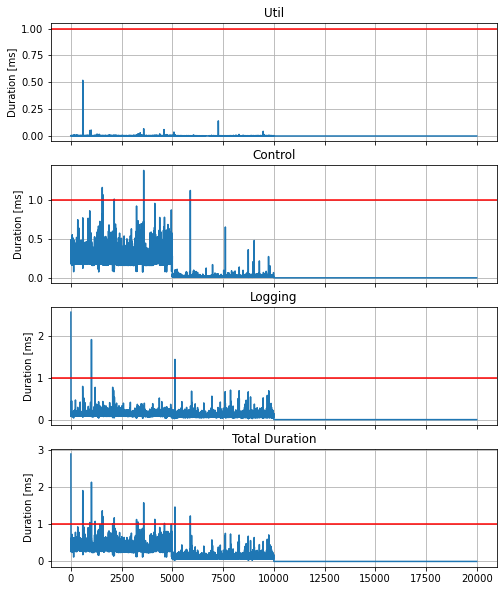

In [9]:
sim_time = 5.0  # seconds
center = [-0.16106215355033854, -0.04274526610493587, 0.164134808398184]

# finger0
gain = 1.
D = np.array([0.3, 0.3, 0.3])
ctrl0 = VelocityController(head0, id0, gain, D, center=center,
                                               radius = 0.04, total_time=sim_time, dt=dt, w=np.pi)
q0 = np.array([0., -0.5, 1])
dq0 = np.array(NYUFingerDoubleConfig0.initial_velocity)
thread_head.heads['finger0'].reset_state(q0, dq0)

# finger1 PD
# P = np.array([4,4,3])
# D = np.array([.5,.4,.2])
# ctrl1 = PD_controller(head1, id1, P, D)
# q1 = np.array(NYUFingerDoubleConfig1.initial_configuration)
# dq1 = np.array(NYUFingerDoubleConfig1.initial_velocity)
# thread_head.heads['finger1'].reset_state(q1, dq1)

# finger1 impedance
K = np.diag([50,50,10])
D = np.diag([5,5,0])
ctrl1 = ImpedanceController(head1, id1, K, D)
q1 = np.array(NYUFingerDoubleConfig1.initial_configuration)
dq1 = np.array(NYUFingerDoubleConfig1.initial_velocity)
thread_head.heads['finger1'].reset_state(q1, dq1)

# start simulation
thread_head.switch_controllers((ctrl0, ctrl1))

thread_head.start_streaming()
thread_head.start_logging()

thread_head.sim_run(int(sim_time/dt), sleep=True)

thread_head.stop_streaming()
thread_head.stop_logging()

# Plot timing information.
thread_head.plot_timing()